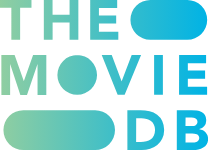

# IMDb Movies Analysis and Predictions

## Business Problem:
For this project, you have been hired to produce a MySQL database on Movies from a subset of IMDB's publicly available dataset. Ultimately, you will use this database to analyze what makes a movie successful and will provide recommendations to the stakeholder on how to make a successful movie.

### Source:  
#### https://datasets.imdbws.com/ .gz

We will focus on the following data files: <br> 
**title.basics.tsv.gz** <br>
**title.ratings.tsv.gz** <br>
**title.akas.tsv.gz** <br>

### Part 4:     
***
#### Apply hypothesis testing to explore what makes a movie successful.

#### **1. Libraries**